In [115]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import time
from matplotlib.collections import PatchCollection
%matplotlib inline

In [127]:
import os

In [187]:
viewingDistance = 100
radius = 10
speed = 4#1
dotNum = 20
timePoints = 500#1000
pixelsPerDegree = 10 
screenWidth = 1200
screenHeight = 800

In [188]:
# function to generate random dot positions at specified distance range from center
def getNewDotPositions(dotNum, minDist=5*pixelsPerDegree, maxDist=90*pixelsPerDegree):
    dists = np.random.uniform(minDist, maxDist, size=dotNum)
    angles = np.pi * np.random.uniform(0, 2, size=dotNum)
    x = dists * np.cos(angles)
    y = dists * np.sin(angles)
    return np.stack([x,y]).T

In [189]:
#pick dots at random screen positions with respect to center point
centerPos=np.array([-60,-20])
pos = getNewDotPositions(dotNum, 5, 10) + centerPos

#find how far they are from center and find unit vectors along which to move them
distToCenter = np.sqrt(np.sum((pos - centerPos)**2, axis=1))
unitVectors = (pos - centerPos)/distToCenter[:, None]

In [190]:
#find the visual angle at which each dot lives
theta = np.deg2rad(distToCenter/pixelsPerDegree)

#find the "time point" when each dot would reach its visual angle if it had started at the original viewing distance
virtualTimePoint = (viewingDistance - (radius/np.tan(theta)))/speed

#probably unnecessary
newTheta = np.copy(theta)
newPos = np.copy(pos)

In [191]:
#Function to repopulate dots that are past 90 degrees visual angle
def repop(repopInds, distToCenter, newPos, unitVectors, newTheta, virtualTimePoint):
    newPos[repopInds] = getNewDotPositions(repopInds.size) + centerPos
    distToCenter[repopInds] = np.sqrt(np.sum((newPos[repopInds] - centerPos)**2, axis=1))
    unitVectors[repopInds] = (newPos[repopInds] - centerPos)/distToCenter[repopInds, None]
    newTheta[repopInds] = np.deg2rad(distToCenter[repopInds]/pixelsPerDegree)
    virtualTimePoint[repopInds] = (viewingDistance - (radius/np.tan(newTheta[repopInds])))/speed
    
    return distToCenter, newPos, unitVectors, newTheta, virtualTimePoint

#Function to redraw dots for the next time point
def redraw(distToCenter, newPos, unitVectors, newTheta, virtualTimePoint):
    #increment "time point" for each dot
    virtualTimePoint += 1
    
    #find new visual angle at that time point
    newTheta = np.arctan(radius/(viewingDistance - speed*(virtualTimePoint+1)))
    
    #convert angle to pixels and update dot positions
    newThetaPix = np.rad2deg(newTheta)*pixelsPerDegree
    newPos = unitVectors*newThetaPix[:, None] + centerPos
    
    #find dots past 90 and reorient them towards the perspective point at 180 degrees
    past90 = np.rad2deg(newTheta)<0
    if np.sum(past90)>0:
        unitVectors_past90 = np.copy(unitVectors[past90])
        unitVectors_past90 = unitVectors_past90 * [-1,1]
        newTheta[past90]  = np.abs(newTheta[past90])
        newThetaPix[past90] = np.rad2deg(newTheta[past90])*pixelsPerDegree
        newPos[past90] = unitVectors_past90*newThetaPix[past90][:,None] + centerPos + [180*pixelsPerDegree,0]
    
    onscreen = np.array([(-screenWidth/2 <p[0]< screenWidth/2) & (-screenHeight/2<p[1]<screenHeight/2) for p in newPos])
    #repop if necessary
    #if not all(onscreen):
    if any(past90 & (np.rad2deg(newTheta)<30)):
        #repopInds = np.where(~onscreen)[0]
        repopInds = np.where(past90 & (np.rad2deg(newTheta)<30))[0]
        distToCenter, newPos, unitVectors, newTheta, virtualTimePoint = repop(repopInds, distToCenter, newPos, unitVectors, newTheta, virtualTimePoint)
    
    return distToCenter, newPos, unitVectors, newTheta, virtualTimePoint

In [192]:
pos_array = []
for i in np.arange(timePoints):
    distToCenter, newPos, unitVectors, newTheta, virtualTimePoint = redraw(distToCenter, newPos, unitVectors, newTheta, virtualTimePoint)
    pos_array.append(newPos)
    

In [193]:
pos_array = np.array(pos_array)
pos_array.shape

(500, 20, 2)

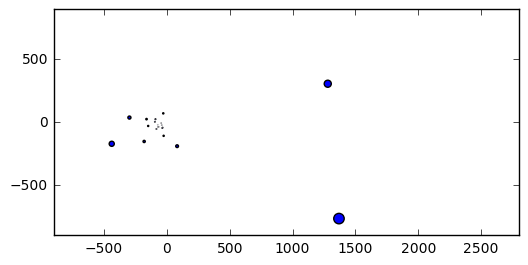

In [194]:
from ipywidgets import widgets, interact, interactive
from IPython.display import display
from IPython.display import Image

scaleFactor = 1/20.
fig, ax = plt.subplots()
ax.set_aspect('equal')
def f(x=0):
    patches = []
    for p in pos_array[x]:
        dist = ((p[0] - centerPos[0])**2 + (p[1]-centerPos[1])**2)**0.5
        dist180 = ((p[0] - centerPos[0] - 180*pixelsPerDegree)**2 + (p[1]-centerPos[1])**2)**0.5
        radius = np.min([dist, dist180])*scaleFactor
        patches.append(matplotlib.patches.Circle((p[0], p[1]), radius=radius, ec='none', fc=[0, 0, 0]))
    
    collection = PatchCollection(patches)
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.add_collection(collection)
    ax.set_ylim([-900, 900])
    ax.set_xlim([-900, 2800])
    #ax.axis('off')
    
interact(f, x=(0,timePoints-1,1));

### Parameters to vary:
- density/number of dots
- speed
- size of dots
- coherence?

2 seconds sweep + 1 second intersweep = 3 second stimulus
forward/back = 2 directions
5 speeds
3 sizes
3 densities
15 trials
+15 blank sweeps

In [107]:
((3*3*5*2*3*15)+(15*3))/60.

68.25

In [124]:
from PIL import Image

In [125]:
impath = r'/Users/saskiad/openscope_motion/stimulus/translation'

In [140]:
for i in range(10,20):
    patches = []
    for p in pos_array[i]:
        dist = ((p[0] - centerPos[0])**2 + (p[1]-centerPos[1])**2)**0.5
        dist180 = ((p[0] - centerPos[0] + 180)**2 + (p[1]-centerPos[1])**2)**0.5
        radius = np.min([dist, dist180])*scaleFactor
        patches.append(matplotlib.patches.Circle((p[0], p[1]), radius=radius, ec='none', fc=[0, 0, 0]))

    collection = PatchCollection(patches)
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.add_collection(collection)
    ax.set_ylim([-45, 45])
    ax.set_xlim([-70, 70])
    ax.axis('off')
    plt.savefig(os.path.join(impath, str(i)+'.png'))
    plt.close()

In [129]:
im = Image.open(os.path.join(impath, str(i)+'.png'))

In [131]:
np_im = np.array(im)

In [132]:
np_im.shape

(288, 432, 4)

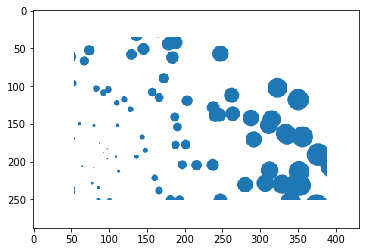

In [138]:
plt.imshow(np_im[:,:,:])

- need to make sure the number of pixels is appropriate
- need to eliminate (or otherwise account for) the border

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in long_scalars
  app.launch_new_instance()


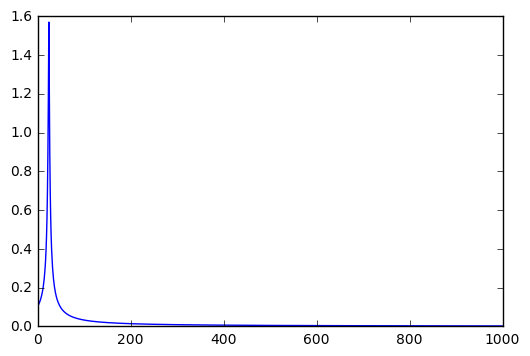

In [13]:
theta = []
for i in np.arange(1000):
    theta.append(np.arctan(radius/(viewingDistance - speed*(i+1))))
plt.plot(np.abs(theta))

In [14]:
np.ones((5,2)) * [-1,1]

array([[-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.]])

In [15]:
unitVectors.shape

(800, 2)

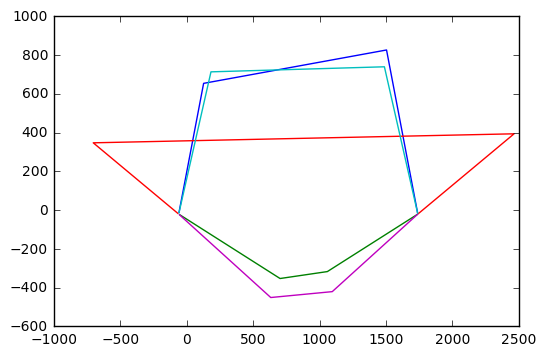

In [126]:
plt.plot(pos_array[:, 5:10, 0], pos_array[:, 5:10, 1])

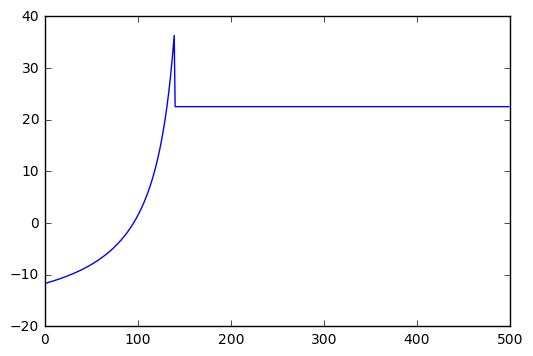

In [107]:
plt.plot(pos_array[:, 1, 1])

In [147]:
onscreen = np.array([(-screenWidth/2 < p[0]< screenWidth/2) & (-screenHeight/2<p[1]<screenHeight/2) for p in newPos])
np.sum(onscreen)
np.where(~onscreen)[0]

array([  7,  13,  24,  30,  31,  37,  42,  53,  55,  73,  76,  79,  80,
        81,  84, 107, 108, 117, 124, 128, 129, 141, 145, 147, 150, 162,
       183, 188, 190, 192, 217, 243, 252, 258, 265, 271, 279, 284, 290,
       291, 303, 310, 314, 325, 349, 361, 365, 377, 378, 381, 394, 403,
       405, 428, 432, 437, 444, 461, 473, 480, 485, 489, 493, 495, 511,
       516, 525, 526, 527, 544, 546, 552, 575, 576, 580, 582, 584, 589,
       594, 600, 605, 607, 628, 630, 631, 632, 638, 643, 663, 669, 673,
       675, 677, 698, 699, 721, 733, 742, 754, 760, 765, 766, 775, 776,
       777, 786])

In [148]:
pos_array[-1, :10]

array([[   2.88128362,   98.80199006],
       [-144.57849129,   -6.36741609],
       [  -9.77601492,  -99.4256373 ],
       [  48.88241822,   15.77910123],
       [ 174.18686903,  104.46199995],
       [-112.2789624 ,   46.285019  ],
       [  96.05444769, -177.4628177 ],
       [-668.5654172 ,  280.6904745 ],
       [ -37.59893041, -102.50771369],
       [ -46.07432978, -101.54637515]])

In [146]:
repopInds

NameError: name 'repopInds' is not defined